

> This notebook presents a complete workflow for tri-class sentiment classification on the FiReCS dataset of Taglish product reviews. The pipeline begins with data loading, cleaning, and a reproducible 80/20 stratified split that preserves class balance and writes split IDs to disk for consistent evaluation across runs. A simple baseline is then established using TF-IDF features with Logistic Regression to provide an interpretable reference score. The workflow proceeds to transformer fine-tuning with two backbones: a multilingual encoder (XLM-RoBERTa) and a Filipino-prior encoder (RoBERTa-Tagalog). Both models are adapted to three sentiment labels and trained using a shared evaluation function that reports macro-F1 and accuracy on the fixed validation split.

> Each section of the notebook follows a consistent structure to aid replication. The preprocessing cell prepares tokenization with a fixed sequence length and converts the data into tensor-ready datasets. The training cell configures arguments, constructs the trainer, performs fine-tuning, evaluates on the validation set, and saves the best checkpoint together with its tokenizer. A brief inference cell verifies behavior on short sample texts, while an analysis cell produces a confusion matrix and a per-class report to explain common errors between negative, neutral, and positive. A final export cell aggregates all runs into a single log, writes spreadsheet summaries for grading and reporting, and highlights the strongest configuration per model.

> The notebook supports both thorough runs and quick sweeps. A fast mode reduces training time by using a smaller training slice and an optional early-stopping callback, which is useful for exploring learning rate, batch size, and epoch count under limited time or hardware. Final headline scores are obtained from full runs that reuse the same split and metric function. Saved checkpoints, split ID files, and exported logs ensure that results can be reproduced and compared fairly across members and model choices.





#### Cell Title: FiReCS Load · Check · Cleaning ·  Split ·  Exports

**Purpose**  
Load the FiReCS dataset into memory, verify that the expected schema is present, perform essential cleaning and type normalization, create a stratified 80/20 train–validation split, and export per-split row identifiers for reproducible downstream processing.

**Input**  
- File dependency: `FiReCS.csv` in the current working directory; if missing, a Colab upload dialog is triggered.  
- Required columns: `review` (text) and `label` (integer sentiment class).  
- Runtime dependencies: `transformers`, `datasets`, `accelerate`, `numpy`, `pandas`, `torch`, `scikit-learn`.

**Output**  
- Console message with active compute device (CPU or CUDA GPU).  
- Console printouts of normalized class proportions for the training and validation splits (sorted by label).  
- Artifacts: `train_ids.csv` and `val_ids.csv`, each containing a single column `id` indicating row membership per split.

**Details**  
Column names are converted to lowercase to avoid case-sensitive key errors. Rows with missing values in `review` or `label` are removed to prevent training or evaluation failures. The `label` column is cast to integer to standardize the target type. Each record receives a unique `id` for traceability without duplicating free-text in split files. A stratified split (`test_size=0.2`, `random_state=42`) preserves class balance between training and validation sets. The printed distributions confirm label balance. Exported CSV files contain only `id` to enable safe joins back to the full dataset later.


In [ ]:
!pip -q install transformers datasets accelerate

import os, numpy as np, pandas as pd, torch, json, inspect
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if not os.path.exists("FiReCS.csv"):
    uploaded = files.upload()
df = pd.read_csv("FiReCS.csv")

df = df.rename(columns={c:c.lower() for c in df.columns})
assert {'review','label'} <= set(df.columns), "CSV must have 'review' and 'label' columns."

df = df.dropna(subset=['review','label']).copy()
df['label'] = df['label'].astype(int)
df['id'] = np.arange(len(df))

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)
print(train_df['label'].value_counts(normalize=True).sort_index())
print(val_df['label'].value_counts(normalize=True).sort_index())

train_df[['id']].to_csv('train_ids.csv', index=False)
val_df[['id']].to_csv('val_ids.csv', index=False)


Using device: cpu
label
0    0.324421
1    0.347241
2    0.328338
Name: proportion, dtype: float64
label
0    0.324251
1    0.347411
2    0.328338
Name: proportion, dtype: float64


#### Cell Title: TF-IDF Features - Logistic Regression Baseline - Evaluation - Run Log

**Purpose**  
Convert training and validation text into TF-IDF features, train a multinomial logistic regression classifier as a baseline, evaluate using accuracy and macro-F1 on the validation set, and append the run summary to `runs_log.csv`.

**Input**  
- DataFrames: `train_df` and `val_df` with columns `review` (text) and `label` (int).  
- Parameters (TF-IDF): `max_features=50_000`, `ngram_range=(1,2)`, `lowercase=True`.  
- Parameters (Logistic Regression): `max_iter=2000`, default solver and multi-class handling, `class_weight=None`.

**Output**  
- Printed metrics dictionary: `{"model":"tfidf-logreg", "accuracy":<float>, "f1_macro":<float>}`.  
- Fitted objects in memory: `tfidf` (vectorizer), `logreg` (classifier).  
- File artifact: Appended row in `runs_log.csv` with model configuration and results (CSV header written only if the file did not previously exist).

**Details**  
The TF-IDF vectorizer learns a vocabulary (up to 50k features) and transforms text to sparse matrices: `X_tr` for training and `X_va` for validation, including unigrams and bigrams. Labels are read as NumPy arrays (`y_tr`, `y_va`). Logistic regression is fitted with up to 2000 iterations to ensure convergence on high-dimensional sparse inputs. Evaluation computes accuracy and macro-averaged F1 (equal weight per class). A structured `row` dictionary captures metadata (member, model, metrics, and fixed `seed` field for tracking), which is appended to `runs_log.csv` (`mode="a"`, `header=not os.path.exists("runs_log.csv")`).


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    lowercase=True
)
X_tr = tfidf.fit_transform(train_df['review'])
y_tr = train_df['label'].values
X_va = tfidf.transform(val_df['review'])
y_va = val_df['label'].values

logreg = LogisticRegression(max_iter=2000, n_jobs=None, class_weight=None)
logreg.fit(X_tr, y_tr)

preds = logreg.predict(X_va)
acc_base = accuracy_score(y_va, preds)
f1_base  = f1_score(y_va, preds, average='macro')
print({"model":"tfidf-logreg", "accuracy":acc_base, "f1_macro":f1_base})

row = {
    "member":"baseline", "model":"tfidf-logreg",
    "num_train_epochs":None, "per_device_train_batch_size":None,
    "learning_rate":None, "weight_decay":None, "warmup_steps":None,
    "lr_scheduler_type":None, "gradient_accumulation_steps":None,
    "max_seq_length":None, "seed":42, "fp16":False,
    "accuracy":acc_base, "f1_macro":f1_base, "notes":"TF-IDF + LogReg baseline"
}
pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",
                           index=False, header=not os.path.exists("runs_log.csv"))


{'model': 'tfidf-logreg', 'accuracy': 0.803133514986376, 'f1_macro': 0.8057244174688569}


#### Cell Title: Tokenizer Setup - HF Datasets Construction - XLM-R Model Initialization

**Purpose**  
Define model selection, initialize a fast tokenizer, convert `train_df` and `val_df` into Hugging Face `Dataset` objects, apply fixed-length tokenization, set PyTorch tensor format, and instantiate a sequence classification model with the required number of labels.

**Input**  
- DataFrames: `train_df`, `val_df` with columns `review` (text) and `label` (int).  
- Model mapping: `MODEL_CHOICES` with short keys to pretrained model IDs.  
- Selection: `MODEL_CHOICE="xlmrb"` → `MODEL_NAME="xlm-roberta-base"`.  
- Tokenization parameters: `MAX_LEN=128`, truncation enabled, padding to max length.  
- Runtime variable: `device` (from prior cell) to move the model to CPU/GPU.

**Output**  
- Console print: active pretrained model ID (e.g., `Using model: xlm-roberta-base`).  
- Two tokenized datasets: `ds_train`, `ds_val` with `input_ids`, `attention_mask`, and `label`.  
- PyTorch formatting applied via `with_format("torch", columns=...)`.  
- Initialized model object: `AutoModelForSequenceClassification` with `num_labels=3` on the selected device.

**Details**  
`AutoTokenizer` with `use_fast=True` applies efficient tokenization compatible with the chosen backbone. The `tokenize_fn` performs truncation and fixed-size padding (`max_length=128`) to ensure uniform tensor shapes for batching. `Dataset.from_pandas` creates HF datasets from the selected columns, and `.map(..., batched=True)` applies vectorized tokenization across rows. The `with_format("torch", columns=[...])` step limits the dataset to tensors required by the trainer/inference loop. The model is instantiated from the pretrained checkpoint with a fresh classification head sized to `num_labels=3`; therefore, initialization logs may report newly initialized classifier weights, indicating the head must be trained on this downstream task.


In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_CHOICES = {
    "xlmrb": "xlm-roberta-base",
    "roberta-tl": "jcblaise/roberta-tagalog-base",
}
MODEL_CHOICE = "xlmrb"
MODEL_NAME = MODEL_CHOICES[MODEL_CHOICE]
print("Using model:", MODEL_NAME)

MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch["review"], truncation=True, padding="max_length", max_length=MAX_LEN)

ds_train = Dataset.from_pandas(train_df[['review','label']].reset_index(drop=True))
ds_val   = Dataset.from_pandas(val_df[['review','label']].reset_index(drop=True))

ds_train = ds_train.map(tokenize_fn, batched=True)
ds_val   = ds_val.map(tokenize_fn, batched=True)

cols = ['input_ids','attention_mask','label']
ds_train = ds_train.with_format("torch", columns=cols)
ds_val   = ds_val.with_format("torch", columns=cols)

num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)


Using model: xlm-roberta-base


Map:   0%|          | 0/5872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1468 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Cell Title: Metrics Function - Training Arguments  - Trainer Initialization

**Purpose**  
Define the validation metrics used during evaluation, build a compatibility-safe factory for `TrainingArguments` that accepts overrides and adapts to available keyword parameters, and construct a Hugging Face `Trainer` with the selected model, datasets, tokenizer, and metric function.

**Input**  
- Precreated objects: `model`, `ds_train`, `ds_val`, `tokenizer`, `device`, and constants such as `MODEL_NAME`.  
- Libraries: `transformers.TrainingArguments`, `transformers.Trainer`, `inspect`, `numpy`, `sklearn.metrics`.  
- Default hyperparameters inside `make_training_args`:
  - `num_train_epochs=3`, `per_device_train_batch_size=16`, `per_device_eval_batch_size=32`  
  - `learning_rate=5e-5`, `weight_decay=0.01`, `warmup_steps=500`, `lr_scheduler_type="linear"`  
  - `gradient_accumulation_steps=1`, `load_best_model_at_end=True`, `metric_for_best_model="f1_macro"`, `seed=42`, `logging_steps=100`, `report_to=[]`  

**Output**  
- Callable `compute_metrics` returning `{'accuracy': <float>, 'f1_macro': <float>}`.  
- Constructed `TrainingArguments` instance (via `make_training_args`) with safe keys filtered against the detected signature.  
- Constructed `Trainer` bound to the given model, datasets, tokenizer, and metric function.  
- Console confirmation: `Trainer ready on: <MODEL_NAME>`.  
- Possible console warning: `tokenizer` argument is deprecated in `Trainer.__init__` and may be removed in v5.0.0 (use of `processing_class` is suggested by the warning).

**Details**  
`compute_metrics` takes `EvalPrediction` from the Trainer, converts logits to predicted class indices with `argmax`, and calculates accuracy and macro-averaged F1 using ground-truth labels. `make_training_args` inspects the constructor of `TrainingArguments` to derive allowable parameter names, merges any provided `**overrides`, supplies evaluation and saving strategies compatible with the current library (`evaluation_strategy`/`eval_strategy`/`eval_steps`, and `save_strategy`/`save_steps`), and toggles `fp16` based on CUDA availability if supported. Unsupported keys are removed before instantiating `TrainingArguments`. The `Trainer` is created with train/eval datasets and the tokenizer so that evaluation and logging proceed with the specified arguments and metrics.


In [ ]:
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1_macro': f1m}

import inspect
sig = inspect.signature(TrainingArguments.__init__)
argnames = set(sig.parameters.keys())

def make_training_args(**overrides):
    cfg = dict(
        output_dir="./results",
        num_train_epochs=3,                 # Candelaria
        per_device_train_batch_size=16,     # Candelaria
        per_device_eval_batch_size=32,
        learning_rate=5e-5,                 # Candelaria
        weight_decay=0.01,                  # Posadas
        warmup_steps=500,                   # Posadas
        lr_scheduler_type="linear",         # Posadas
        gradient_accumulation_steps=1,      # Tumulak
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",   # Tumulak
        seed=42,                            # Tumulak
        logging_steps=100,
        report_to=[]
    )
    cfg.update(overrides)

    if "evaluation_strategy" in argnames:
        cfg["evaluation_strategy"] = cfg.get("evaluation_strategy","epoch")
    elif "eval_strategy" in argnames:
        cfg["eval_strategy"] = cfg.get("eval_strategy","epoch")
    else:
        cfg["eval_steps"] = cfg.get("eval_steps", 500)

    if "save_strategy" in argnames:
        cfg["save_strategy"] = cfg.get("save_strategy","epoch")
    else:
        cfg["save_steps"] = cfg.get("save_steps", 500)

    if "fp16" in argnames:
        cfg["fp16"] = bool(torch.cuda.is_available()) if "fp16" not in cfg else cfg["fp16"]

    safe_cfg = {k:v for k,v in cfg.items() if k in argnames}
    return TrainingArguments(**safe_cfg)

training_args = make_training_args()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("Trainer ready on:", MODEL_NAME)


Trainer ready on: xlm-roberta-base


/tmp/ipython-input-139214311.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### Cell Title: Fast Subset Bootstrap · Callback Setup · Config Echo

**Purpose**  
Create a reduced training subset (`ds_train_fast`) for quicker experimentation, mirror the full validation set into `ds_val_fast`, set up optional early stopping callbacks when available, and print the effective run configuration (epochs, batch size, eval steps, and subset sizes).

**Input**  
- Pre-existing datasets: `ds_train`, `ds_val` (Hugging Face Datasets already tokenized and set to torch format).  
- Optional globals (taken if defined elsewhere; defaults used otherwise):  
  - `EPOCHS` (default `1`)  
  - `BATCH` (default `32`)  
  - `EVAL_STEPS` (default `200`)  
  - `TRAIN_FRACTION` (default `0.20`, i.e., 20% of `ds_train`)  
  - `callbacks` (optional; if absent, an EarlyStopping callback is created when available)

**Output**  
- New datasets in memory:  
  - `ds_train_fast` (subset of `ds_train`; minimum 8 examples or `ceil(TRAIN_FRACTION * len(ds_train))`)  
  - `ds_val_fast` (alias of `ds_val`)  
- Optional list: `callbacks` containing `EarlyStoppingCallback(early_stopping_patience=1)` if import succeeds.  
- Console line confirming configuration and subset size, e.g.:  
  `[BOOTSTRAP] EPOCHS=1, BATCH=32, EVAL_STEPS=200, train_fast=1174 / 5872`.

**Details**  
The subset logic selects the first *n* examples from `ds_train` where `n = max(8, int(len(ds_train) * TRAIN_FRACTION))`. This creates a small but representative slice for faster iteration while preserving a non-trivial minimum size. Validation is not downsampled to keep evaluation stable across quick tests. If a global `callbacks` is not already defined, the cell attempts to import `EarlyStoppingCallback` from `transformers` and initializes it with `early_stopping_patience=1`; if the import fails, callbacks remain `None`. The printed configuration confirms the values in effect for subsequent training cells.


In [ ]:
import math, numpy as np
from transformers import Trainer

EPOCHS = globals().get('EPOCHS', 1)
BATCH = globals().get('BATCH', 32)
EVAL_STEPS = globals().get('EVAL_STEPS', 200)
TRAIN_FRACTION = globals().get('TRAIN_FRACTION', 0.20)

if 'ds_train_fast' not in globals():
    assert 'ds_train' in globals() and 'ds_val' in globals(), "Need ds_train/ds_val first."
    n_fast = max(8, int(len(ds_train) * TRAIN_FRACTION))
    ds_train_fast = ds_train.select(range(n_fast))
    ds_val_fast = ds_val

callbacks = globals().get('callbacks', None)
if callbacks is None:
    try:
        from transformers import EarlyStoppingCallback
        callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]
    except Exception:
        callbacks = None

print(f"[BOOTSTRAP] EPOCHS={EPOCHS}, BATCH={BATCH}, EVAL_STEPS={EVAL_STEPS}, "
      f"train_fast={len(ds_train_fast)} / {len(ds_train)}")


[BOOTSTRAP] EPOCHS=1, BATCH=32, EVAL_STEPS=200, train_fast=1174 / 5872


#### Cell Title: Train -  Evaluate - Save Best - Log Run

**Purpose**  
Execute supervised fine-tuning with `Trainer.train()`, run validation with `Trainer.evaluate()`, persist the best model and tokenizer artifacts to a versioned folder, and append a structured record of configuration and scores to `runs_log.csv`.

**Input**  
- Objects: `trainer`, `training_args`, `tokenizer`, `MODEL_NAME`, `MAX_LEN`.  
- Datasets and model are already bound to `trainer` from earlier cells.  
- Filesystem: writable working directory for saving the model folder and appending to `runs_log.csv`.

**Output**  
- In-memory: `train_out` (training result object), `eval_results` (dict of eval metrics).  
- Console: printed evaluation metrics (`Eval: {...}`), status lines during training, and a final “Logged run for: <MODEL_NAME>”.  
- Files: saved model directory `./finetuned_<MODEL_NAME>_best` (weights, config, tokenizer) and an appended row in `runs_log.csv`.  
- Possible runtime notes: e.g., `UserWarning` about `pin_memory=True` without an accelerator and periodic Trainer progress lines (loss, steps, epochs).

**Details**  
`trainer.train()` performs the full training loop as configured in `training_args`. `trainer.evaluate()` computes metrics on the evaluation dataset using the `compute_metrics` function registered earlier; keys typically include `eval_loss`, `eval_accuracy`, and `eval_f1_macro`. The save path replaces `/` in `MODEL_NAME` to create a safe folder name. `trainer.save_model(save_dir)` writes the model and training configuration; `tokenizer.save_pretrained(save_dir)` stores tokenizer vocab and config. A logging row collects core hyperparameters from `training_args` (epochs, batch size, learning rate, weight decay, warmup steps, scheduler, accumulation steps, seed, fp16) plus `MAX_LEN` and resulting metrics, then appends to `runs_log.csv` with header written only if the file does not already exist.


In [ ]:
train_out = trainer.train()
eval_results = trainer.evaluate()
print("Eval:", eval_results)

save_dir = f"./finetuned_{MODEL_NAME.replace('/','_')}_best"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

row = {
    "member":"team",
    "model": MODEL_NAME,
    "num_train_epochs": float(getattr(training_args, "num_train_epochs", np.nan)),
    "per_device_train_batch_size": int(getattr(training_args, "per_device_train_batch_size", np.nan)),
    "learning_rate": float(getattr(training_args, "learning_rate", np.nan)),
    "weight_decay": float(getattr(training_args, "weight_decay", np.nan)),
    "warmup_steps": int(getattr(training_args, "warmup_steps", np.nan)),
    "lr_scheduler_type": str(getattr(training_args, "lr_scheduler_type", "")),
    "gradient_accumulation_steps": int(getattr(training_args, "gradient_accumulation_steps", np.nan)),
    "max_seq_length": MAX_LEN,
    "seed": int(getattr(training_args, "seed", 42)),
    "fp16": bool(getattr(training_args, "fp16", False)),
    "accuracy": float(eval_results.get("eval_accuracy", np.nan)),
    "f1_macro": float(eval_results.get("eval_f1_macro", np.nan)),
    "notes":"EF1 Transformers fine-tune"
}
pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",
                           index=False, header=not os.path.exists("runs_log.csv"))
print("Logged run for:", MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


#### Cell Title: Inference Pipeline - Batch Sentiment Predictions - Console Preview

**Purpose**  
Instantiate a Hugging Face `pipeline` for text classification using the fine-tuned model and tokenizer, run batch predictions on sample Taglish reviews, and print each input alongside its predicted label and confidence score.

**Input**  
- Objects: `model` and `tokenizer` already created in earlier cells.  
- Device selection: GPU index `0` if `torch.cuda.is_available()` is `True`; otherwise CPU (`-1`).  
- Sample texts list `samples` containing short Taglish product-review sentences.

**Output**  
- Variable: `preds` — list of dictionaries (one per input) with keys `label` and `score`.  
- Console: for each input text, a two-line preview showing the original text and its corresponding prediction dictionary.  
- Labels: values follow the model’s internal `id2label` mapping; if not customized, they appear as `LABEL_0`, `LABEL_1`, `LABEL_2`.  
- Scores: floats in `[0,1]` representing the predicted class probability after softmax.

**Details**  
The `pipeline("text-classification", ...)` performs tokenization, model forward pass, and softmax scoring. Device selection uses `0` for the first CUDA device or `-1` for CPU. The call with a Python list triggers vectorized batch inference. The returned `label` strings map to class IDs as defined in `model.config.id2label`; customize this mapping during fine-tuning to display human-readable class names (e.g., `negative`, `neutral`, `positive`). The printed preview is formatted for quick inspection and does not write files or alter model state.


In [ ]:
from transformers import pipeline
sentiment_analyzer = pipeline(
    "text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1
)

samples = [
    "Ang bilis ng delivery, pero sira yung box.",
    "solid yung quality, sakto ang size. sulit!",
    "medyo pangit yung tela, tapos delay pa courier :("
]
preds = sentiment_analyzer(samples)
for t, r in zip(samples, preds):
    print(f"{t}\n -> {r}\n")


Device set to use cpu


Ang bilis ng delivery, pero sira yung box.
 -> {'label': 'LABEL_0', 'score': 0.4898853600025177}

solid yung quality, sakto ang size. sulit!
 -> {'label': 'LABEL_2', 'score': 0.7228704690933228}

medyo pangit yung tela, tapos delay pa courier :(
 -> {'label': 'LABEL_0', 'score': 0.5115751624107361}



#### Cell Title: Validation Predictions - Confusion Matrix Visualization - Classification Report Table

**Purpose**  
Generate validation predictions from the trained `trainer`, compute a confusion matrix and a per-class classification report, render the confusion matrix as an image with counts, and present detailed precision/recall/F1/support metrics as a DataFrame for inspection and export.

**Input**  
- Object: `trainer` already fitted and bound to `ds_val`.  
- Dataset: `ds_val` in Hugging Face `Dataset` format with integer labels `{0,1,2}`.  
- Label mapping used for display: index → `['neg','neu','pos']` for ticks and `['negative','neutral','positive']` for the report.

**Output**  
- Variables: `pred` (Trainer predictions object), `y_true` (ground-truth int labels), `y_pred` (argmax over logits).  
- Figure: Confusion matrix heatmap with integer counts annotated per cell, axes labeled “True” and “Predicted” with class ticks.  
- Table: `df_report` (Pandas DataFrame) containing precision, recall, F1-score, and support for each class, plus overall `accuracy`, `macro avg`, and `weighted avg`.  
- Example metrics from this run:  
  - `negative`: precision 0.5349, recall 0.7248, F1 0.6155 (support 476)  
  - `neutral`: precision 0.4860, recall 0.2039, F1 0.2873 (support 510)  
  - `positive`: precision 0.6585, recall 0.8320, F1 0.7351 (support 482)  
  - overall accuracy: 0.5790; macro F1: 0.5460; weighted F1: 0.5408

**Details**  
`trainer.predict(ds_val)` returns logits and labels; `np.argmax(..., axis=1)` converts logits to predicted class indices. `confusion_matrix(y_true, y_pred, labels=[0,1,2])` builds a fixed-order matrix to align with the tick labels. `plt.imshow(cm, interpolation='nearest')` renders the matrix; looped `plt.text` overlays raw counts for each cell. `classification_report(..., output_dict=True)` yields per-class and aggregate metrics, which are converted to a DataFrame and transposed for row-oriented readability. The report uses explicit `target_names` to align numeric labels `{0,1,2}` with `['negative','neutral','positive']`.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


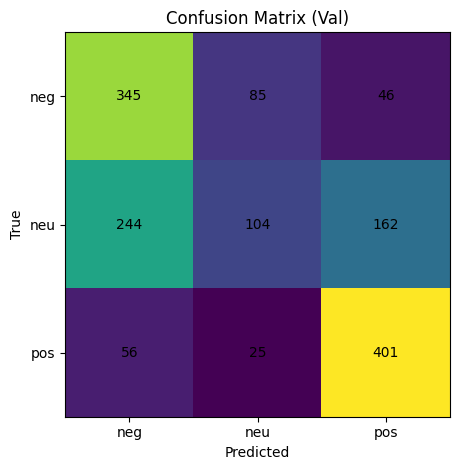

,precision,recall,f1-score,support
negative,0.534884,0.724790,0.615522,476.000000
neutral,0.485981,0.203922,0.287293,510.000000
positive,0.658456,0.831950,0.735105,482.000000
accuracy,0.579019,0.579019,0.579019,0.579019
macro avg,0.559774,0.586887,0.545973,1468.000000
weighted avg,0.558468,0.579019,0.540755,1468.000000


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

pred = trainer.predict(ds_val)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Val)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1,2], ['neg','neu','pos'])
plt.yticks([0,1,2], ['neg','neu','pos'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred, labels=[0,1,2],
                               target_names=['negative','neutral','positive'],
                               output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report


#### Cell Title: Merge Run Logs · Normalize Schema · Aggregate Summaries · Export Reports

**Purpose**  
Collect experiment runs from `runs_log.csv` and (optionally) a team template file `Experiment_Log_Template.xlsx`, normalize column names and align schemas, combine records without duplicates, compute summary views (best per model, runs per model, top 10 by macro-F1), and export consolidated results to `exports/` in both CSV and Excel formats.

**Input**  
- Files (if present):  
  - `runs_log.csv` — appended by training/evaluation cells with configuration and metrics.  
  - `Experiment_Log_Template.xlsx` — team log to be merged with the current runs.  
- Assumed fields (when available): `model`, `f1_macro`, and other hyperparameter/metadata columns.

**Output**  
- Directory: `exports/` (created if absent).  
- Consolidated table:  
  - `exports/Experiment_Runs_All.csv` and `exports/Experiment_Runs_All.xlsx` — merged, de-duplicated, and (if available) sorted by `f1_macro` descending.  
- Summary tables (written only if required columns exist):  
  - `exports/Best_by_Model.csv` and `.xlsx` — top row per unique `model` chosen by highest `f1_macro`.  
  - `exports/Runs_per_Model.csv` and `.xlsx` — count of runs grouped by `model`.  
  - `exports/Top10_by_F1.csv` and `.xlsx` — ten highest `f1_macro` rows.  
- Console: “Exported logs to exports/.” or “No logs found yet.”

**Details**  
The cell creates `exports/` via `Path('exports').mkdir(exist_ok=True)`. If both logs are present, column names are lowercased, unioned (`all_cols`), and each DataFrame is reindexed to the full set so schemas match before concatenation. `pd.concat(..., ignore_index=True).drop_duplicates()` removes duplicate rows. When the combined DataFrame is non-empty and includes `f1_macro`, it is sorted descending before export. Excel writes are wrapped in a `try/except` block to handle environments lacking Excel support. `Best_by_Model` is derived by sorting by `f1_macro` then calling `drop_duplicates(subset=['model'])`. `Runs_per_Model` uses `value_counts()` on `model`. `Top10_by_F1` selects the first ten rows after the sort.


In [ ]:
from pathlib import Path
outdir = Path('exports'); outdir.mkdir(exist_ok=True)

df_runs = pd.read_csv('runs_log.csv') if os.path.exists('runs_log.csv') else pd.DataFrame()
if os.path.exists('Experiment_Log_Template.xlsx'):
    df_team = pd.read_excel('Experiment_Log_Template.xlsx')
    for d in (df_runs, df_team):
        d.columns = [str(c).strip().lower() for c in d.columns]
    all_cols = sorted(set(df_runs.columns) | set(df_team.columns))
    df_runs = df_runs.reindex(columns=all_cols)
    df_team = df_team.reindex(columns=all_cols)
    df_all = pd.concat([df_team, df_runs], ignore_index=True).drop_duplicates()
else:
    df_all = df_runs

if not df_all.empty:
    if 'f1_macro' in df_all.columns:
        df_all = df_all.sort_values(by='f1_macro', ascending=False)
    df_all.to_csv(outdir/'Experiment_Runs_All.csv', index=False)
    try:
        df_all.to_excel(outdir/'Experiment_Runs_All.xlsx', index=False)
    except Exception as e:
        print("Excel export error:", e)

    if 'model' in df_all.columns and 'f1_macro' in df_all.columns:
        best_by_model = df_all.sort_values('f1_macro', ascending=False).drop_duplicates(subset=['model'])
        best_by_model.to_csv(outdir/'Best_by_Model.csv', index=False)
        best_by_model.to_excel(outdir/'Best_by_Model.xlsx', index=False)

        rpm = df_all['model'].value_counts().rename_axis('model').reset_index(name='runs')
        rpm.to_csv(outdir/'Runs_per_Model.csv', index=False)
        rpm.to_excel(outdir/'Runs_per_Model.xlsx', index=False)

    if 'f1_macro' in df_all.columns:
        top10 = df_all.head(10)
        top10.to_csv(outdir/'Top10_by_F1.csv', index=False)
        top10.to_excel(outdir/'Top10_by_F1.xlsx', index=False)
    print("Exported logs to exports/.")
else:
    print("No logs found yet.")


Exported logs to exports/.
